# (13) OOD — src: MNIST

**Motivation**: host = ```Chewie```, device = ```cuda:1``` <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-vae/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-vae/figs')
tmp_dir = os.path.join(git_dir, 'jb-vae/tmp')

# GitHub
# sys.path.insert(0, os.path.join(git_dir, '_PoissonVAE'))
sys.path.insert(0, os.path.join(git_dir, '_IterativeVAE'))
from figures.fighelper import *
from vae.train_vae import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
from base.utils_model import load_quick
from figures.analysis import plot_convergence
from figures.imgs import plot_weights

device_idx = 1
device = f'cuda:{device_idx}'

print(f"device: {device}  ———  host: {os.uname().nodename}")

device: cuda:1  ———  host: chewie

In [3]:
from analysis.ood import *

## Poisson, MLP decoder

In [4]:
models2load = {
    'iterative': dict(
        model_name='poisson_MNIST_t-32_z-[128]_<jacob|mlp>',
        fit_name='u:(8.0)-du:(7.0)_b200-ep500-lr(0.002)_beta(16:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,10:55)',
        device=device,
        shuffle=False,
    ),
    'amortized': dict(
        model_name='poisson_MNIST_t-1_z-[128]_<mlp|mlp>',
        fit_name='b200-ep500-lr(0.002)_beta(1:0x0.1)_temp(0.05:lin-0.5)_gr(50)_(2024_09_13,17:45)',
        device=device,
        shuffle=False,
    )
}

In [5]:
trainers = {
    name: load_model(**kwargs)[0] for
    name, kwargs in models2load.items()
}
tr = trainers['iterative']

100%|█████████████████████████████████| 50/50 [01:56<00:00,  2.33s/it]


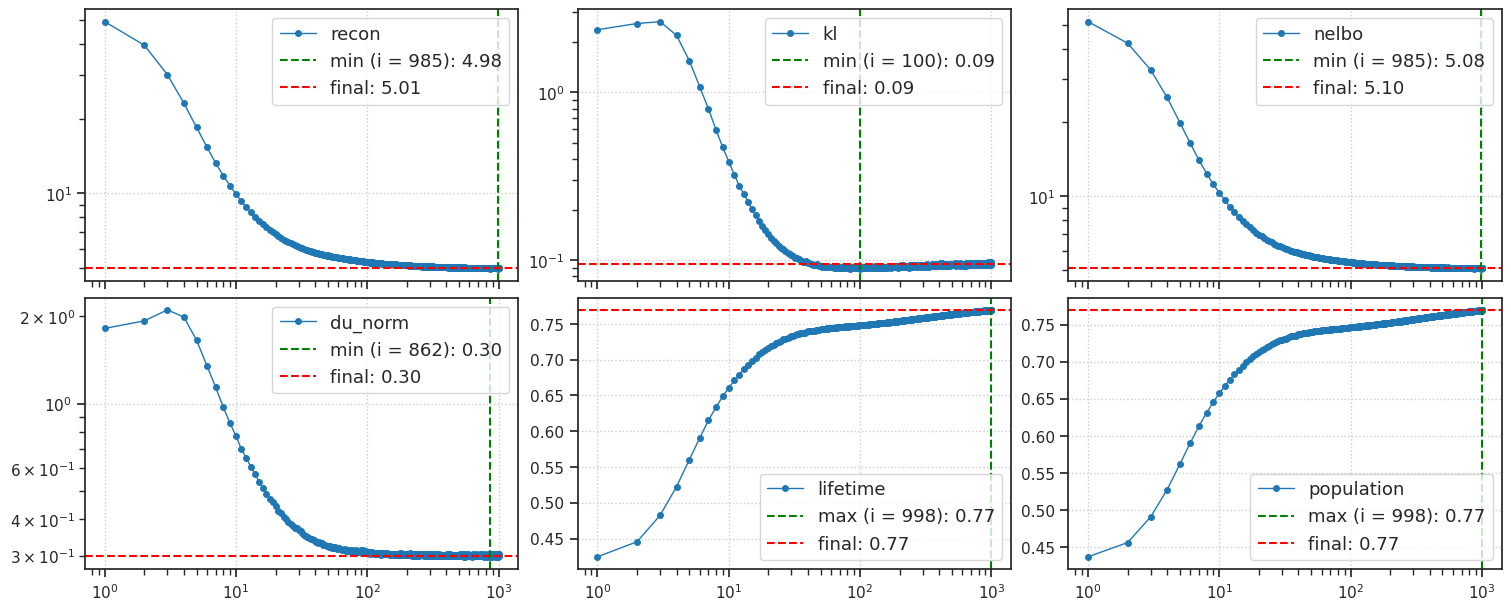

In [6]:
results = tr.analysis('vld', seq_total=1000)
_ = plot_convergence(results, color='C0')

In [7]:
list(tr.stats['grad'])[-1], tr.model.cfg.init_scale

(149999, 0.05)

## EMNIST

### iterative

In [6]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['iterative'],
    dataset='EMNIST',
    t_decay=int(1e5),
)

CPU times: user 15min 18s, sys: 36.9 s, total: 15min 55s
Wall time: 6min 39s


In [7]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      14.67
clf accuracy:   0.775

In [8]:
order = np.argsort(powers)
(~np.isfinite(powers)).sum()

0

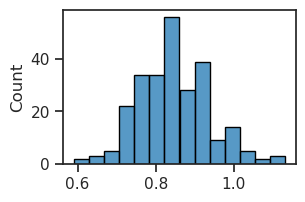

In [9]:
sns.histplot(powers, edgecolor='k');

In [10]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

In [11]:
print(sp_stats.pearsonr(powers, results_decay['recon'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['nelbo'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['kl'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['du_norm'][:, -1]))

PearsonRResult(statistic=-0.4414263198531161, pvalue=1.2397912457916822e-13)

PearsonRResult(statistic=-0.43940383016633733, pvalue=1.6488121850066126e-13)

PearsonRResult(statistic=-0.20215445930914203, pvalue=0.00114480873444874)

PearsonRResult(statistic=0.06280009909686497, pvalue=0.31688842949896606)

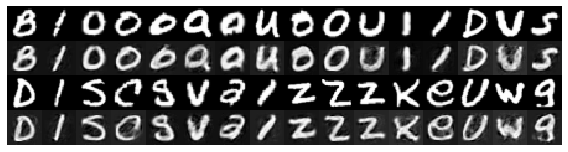

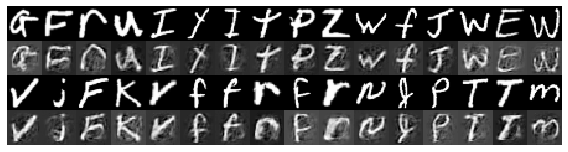

In [12]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

In [13]:
control = results_decay['recon'][order[-16:]].mean(0)
challenge = results_decay['recon'][order[:16]].mean(0)

mode = 'powerlaw'

params_control = fit_decay(control, mode=mode)
params_challenge = fit_decay(challenge, mode=mode)

print(params_control)
print(params_challenge)

[73.0233548   1.03372704  8.22431064]

[63.32469929  0.67421249 26.10840382]

In [14]:
times = np.arange(len(control))
if mode == 'powerlaw':
    times += 1

f = exp_decay if mode == 'exp' else powerlaw_decay
fit_control = f(times, *params_control)
fit_challenge = f(times, *params_challenge)

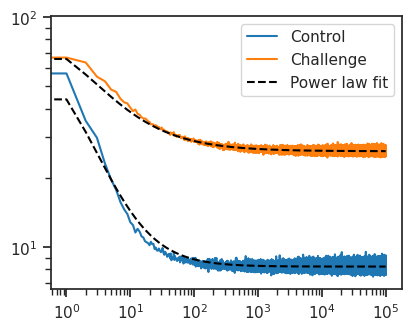

In [15]:
fig, ax = create_figure(1, 1, (4, 3.2))
ax.loglog(control, color='C0', label='Control')
ax.loglog(fit_control, color='k', ls='--')

ax.loglog(challenge, color='C1', label='Challenge')
ax.loglog(fit_challenge, color='k', label='Power law fit', ls='--')

add_legend(ax)
plt.show()

### amortized

In [19]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['amortized'],
    dataset='EMNIST',
)

CPU times: user 27.3 s, sys: 408 ms, total: 27.7 s
Wall time: 2.09 s


In [39]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      50.68
clf accuracy:   0.641

In [28]:
order = np.argsort(results_decay['recon'][:, -1])[::-1]

In [29]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

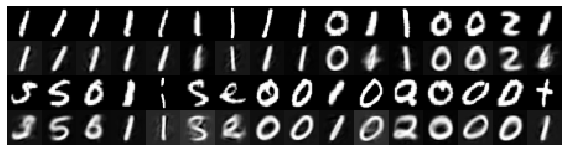

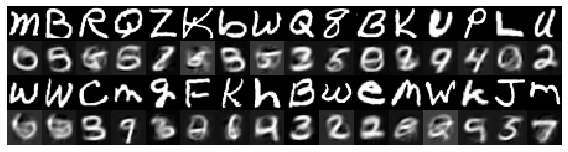

In [30]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

## Omniglot

### iterative

In [16]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['iterative'],
    dataset='Omniglot',
    t_decay=int(1e5),
)

CPU times: user 16min 8s, sys: 47.9 s, total: 16min 56s
Wall time: 6min 36s


In [17]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      21.27
clf accuracy:   0.001

In [18]:
order = np.argsort(powers)
(~np.isfinite(powers)).sum()

0

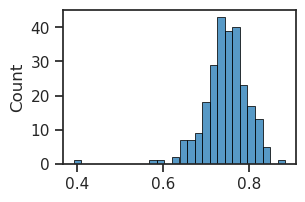

In [19]:
sns.histplot(powers, edgecolor='k');

In [20]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

In [21]:
print(sp_stats.pearsonr(powers, results_decay['recon'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['nelbo'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['kl'][:, -1]))
print(sp_stats.pearsonr(powers, results_decay['du_norm'][:, -1]))

PearsonRResult(statistic=-0.42669492775216394, pvalue=9.477843730648175e-13)

PearsonRResult(statistic=-0.4311767696907166, pvalue=5.157861695911238e-13)

PearsonRResult(statistic=-0.3587495150500695, pvalue=3.425409941095927e-09)

PearsonRResult(statistic=-0.3413020080501838, pvalue=2.1035887632713347e-08)

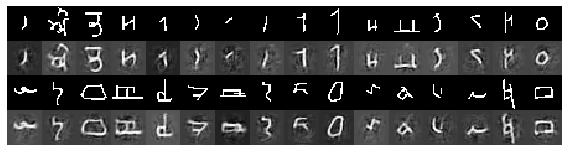

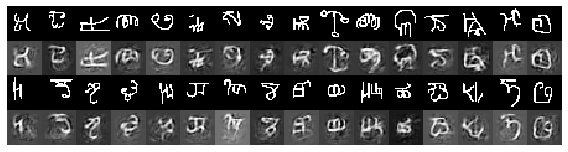

In [22]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

In [23]:
control = results_decay['recon'][order[-16:]].mean(0)
challenge = results_decay['recon'][order[:16]].mean(0)

mode = 'powerlaw'

params_control = fit_decay(control, mode=mode)
params_challenge = fit_decay(challenge, mode=mode)

print(params_control)
print(params_challenge)

[51.14905808  0.83442611  9.80242077]

[52.28823438  0.63371378 29.37239842]

In [24]:
times = np.arange(len(control))
if mode == 'powerlaw':
    times += 1

f = exp_decay if mode == 'exp' else powerlaw_decay
fit_control = f(times, *params_control)
fit_challenge = f(times, *params_challenge)

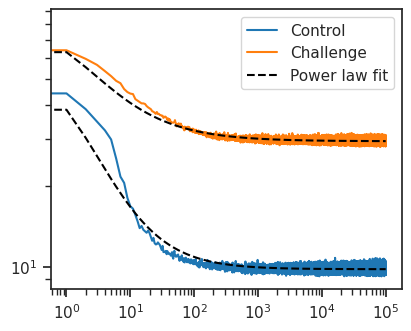

In [25]:
fig, ax = create_figure(1, 1, (4, 3.2))
ax.loglog(control, color='C0', label='Control')
ax.loglog(fit_control, color='k', ls='--')

ax.loglog(challenge, color='C1', label='Challenge')
ax.loglog(fit_challenge, color='k', label='Power law fit', ls='--')

add_legend(ax)
plt.show()

### amortized

In [26]:
%%time

clf_report, results_decay, powers = ood_analysis(
    tr=trainers['amortized'],
    dataset='Omniglot',
)

CPU times: user 2min 24s, sys: 14.4 s, total: 2min 39s
Wall time: 4.14 s


In [27]:
msg = '\n'.join([
    f"recon mse:\t{results_decay['recon'][:, -1].mean():0.2f}",
    f"clf accuracy:\t{clf_report['accuracy']:0.3f}",
])
print(msg)

recon mse:      56.89
clf accuracy:   0.001

In [28]:
order = np.argsort(results_decay['recon'][:, -1])[::-1]

In [29]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_decay['x'])
y = tonp(results_decay['y'][:, -1, :])
y = y.reshape(shape)

x_challenge, y_challenge = x[order], y[order]
x_control, y_control = x[order[::-1]], y[order[::-1]]

num = 16
x2p_control, x2p_challenge = [], []
for i in range(2):
    intvl = range(i * num, (i+1) * num)
    x2p_control.extend([x_control[intvl], y_control[intvl]])
    x2p_challenge.extend([x_challenge[intvl], y_challenge[intvl]])
x2p_control = np.concatenate(x2p_control)
x2p_challenge = np.concatenate(x2p_challenge)

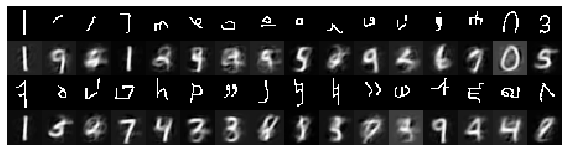

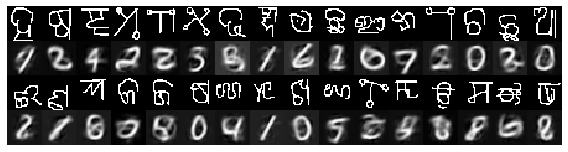

In [30]:
_ = plot_weights(x2p_control, nrows=int(len(x2p_control) / num), pad=0, dpi=70)
_ = plot_weights(x2p_challenge, nrows=int(len(x2p_challenge) / num), pad=0, dpi=70)

## Older omni

In [ ]:
trn, vld = make_dataloader('Omniglot', tr.device)
omni = {'trn': trn, 'vld': vld}

In [9]:
%%time

kws = dict(
    seq_total=1000,
    seq_batch_sz=1000,
    n_data_batches=None,
    return_recon=False,
    full_data=True,
)
results_omni = {
    name: tr.analysis(dl, **kws)
    for name, dl in omni.items()
}

100%|█████████████████████████████████| 52/52 [02:21<00:00,  2.72s/it]


CPU times: user 5min 48s, sys: 6.04 s, total: 5min 54s
Wall time: 5min 53s


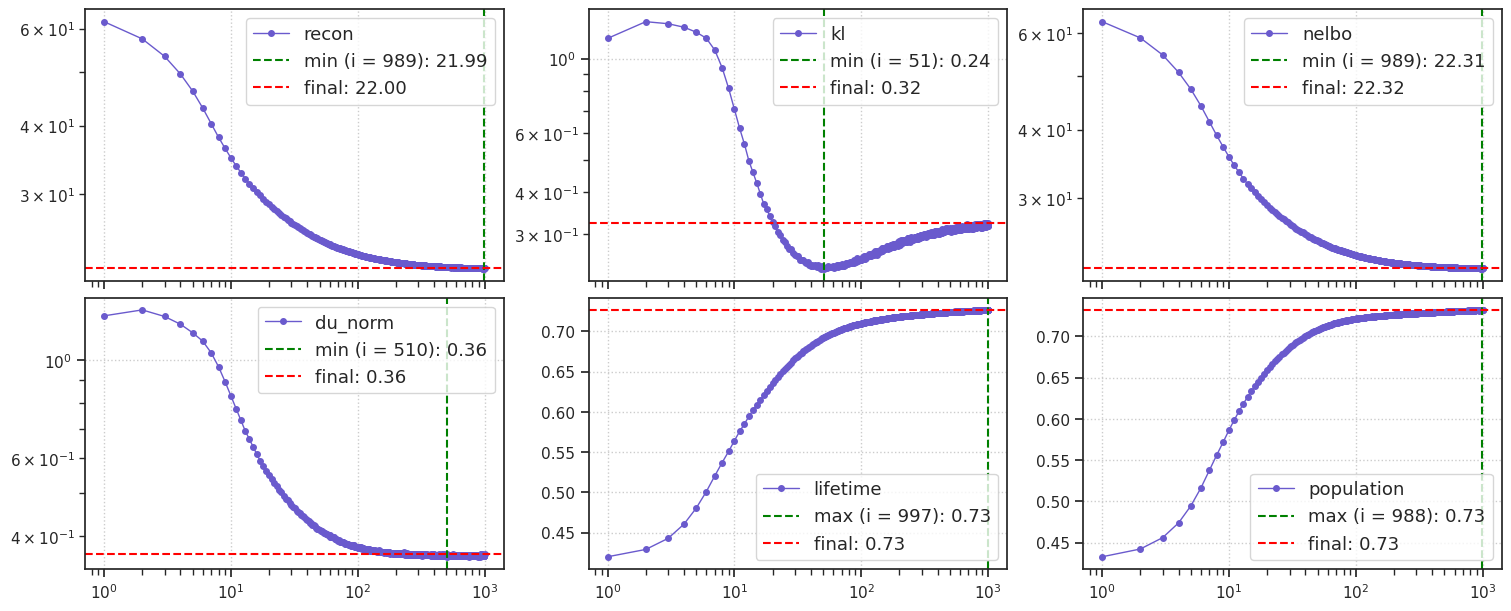

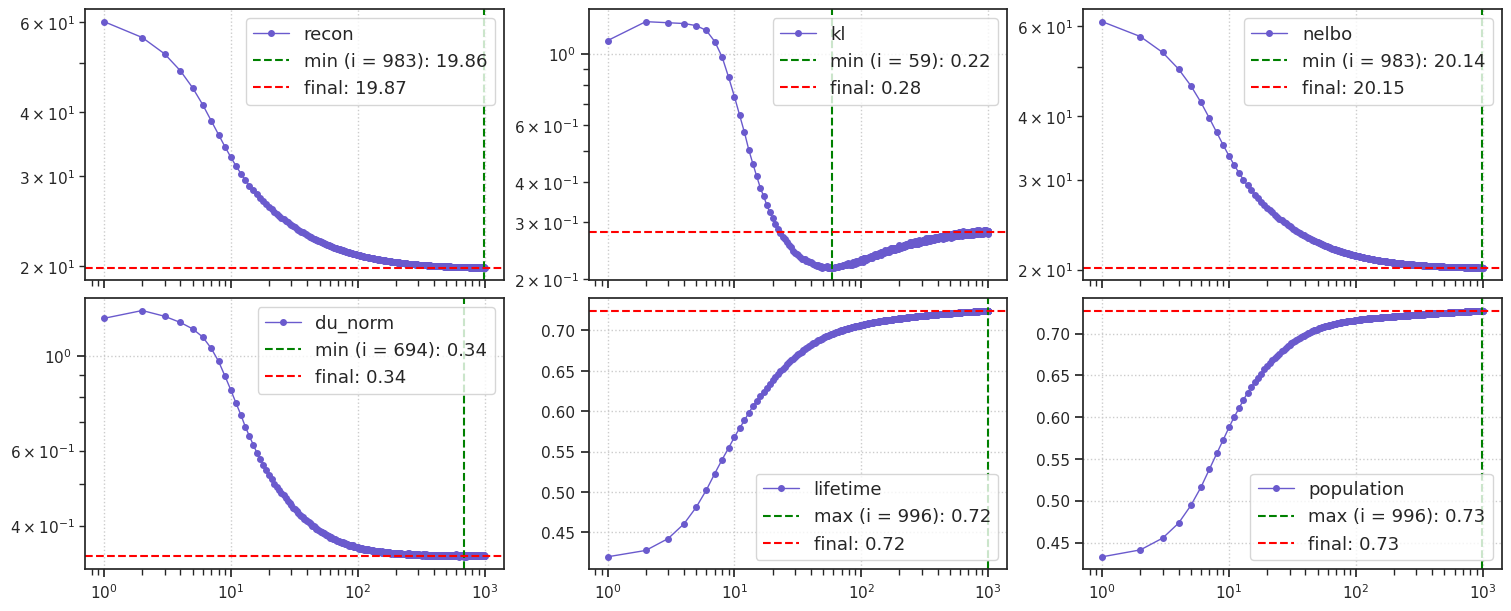

In [11]:
_ = plot_convergence(results_omni['vld'], color='slateblue')
_ = plot_convergence(results_omni['trn'], color='slateblue')

In [13]:
results_omni['vld']['g'].shape

(13180,)

In [17]:
len(np.unique(results_omni['vld']['g'])), len(np.unique(results_omni['trn']['g']))

(659, 964)

100%|█████████████████████████████████| 10/10 [02:18<00:00, 13.89s/it]


CPU times: user 4min 40s, sys: 4.23 s, total: 4min 44s
Wall time: 4min 44s


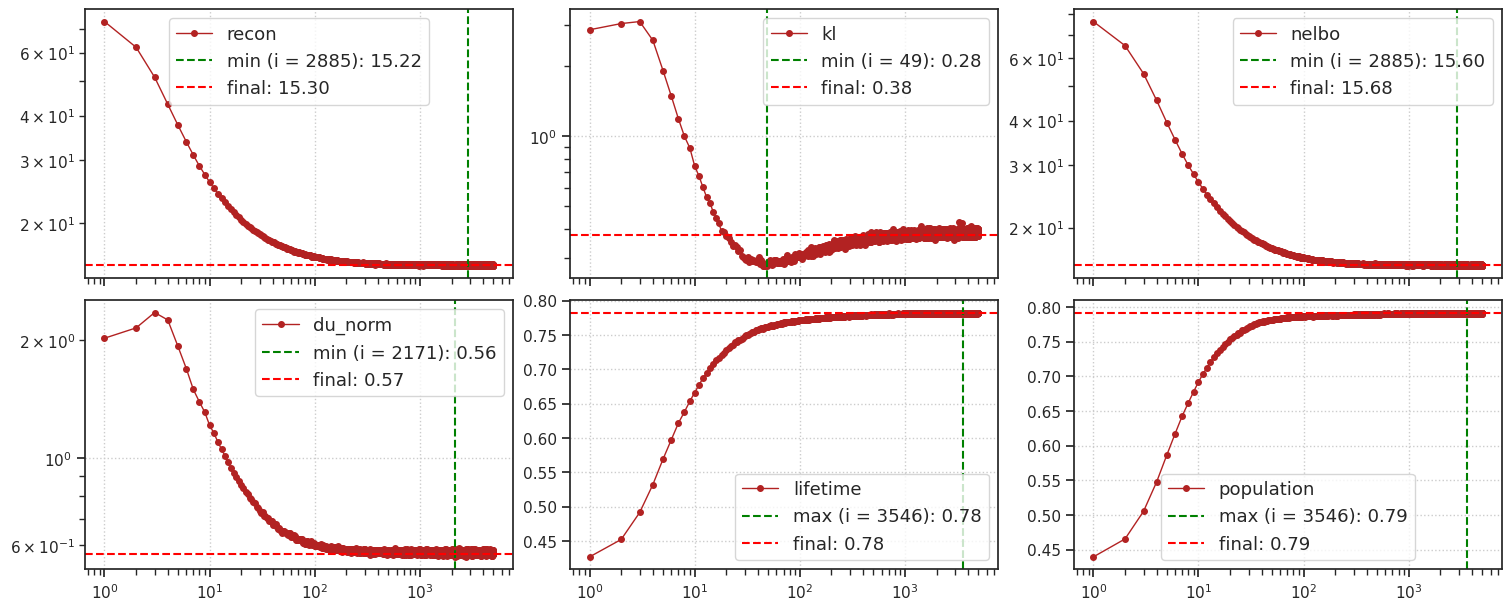

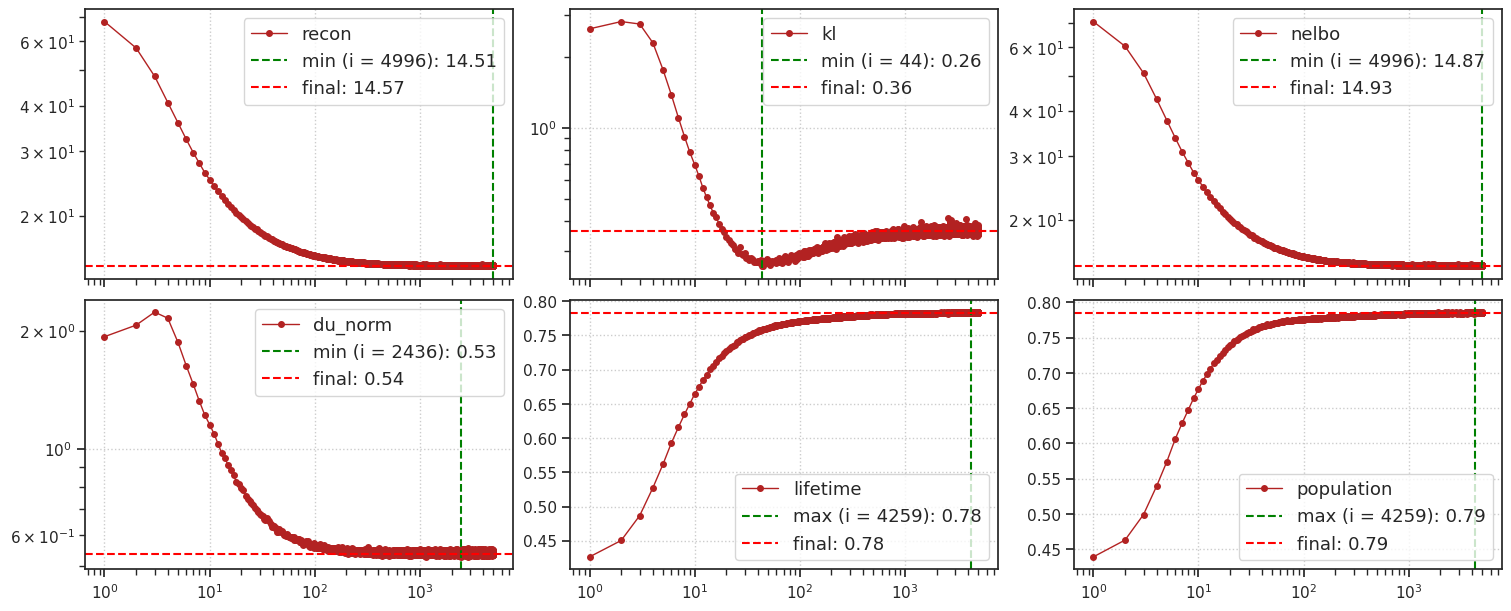

In [22]:
_ = plot_convergence(results_emnist['vld'], color='firebrick')
_ = plot_convergence(results_emnist['trn'], color='firebrick')

In [26]:
np.unique(results_emnist['vld']['g']), np.unique(results_emnist['trn']['g'])

(array([1., 2., 3., 4.], dtype=float32),
 array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.],
       dtype=float32))

In [16]:
%%time

kws = dict(
    seq_total=50000,
    seq_batch_sz=1000,
    n_data_batches=1,
    return_recon=True,
    full_data=True,
)
results_omni_plot = tr.analysis(omni['vld'], **kws)

100%|██████████████████████████████████| 1/1 [02:39<00:00, 159.73s/it]


CPU times: user 2min 47s, sys: 13.6 s, total: 3min
Wall time: 3min


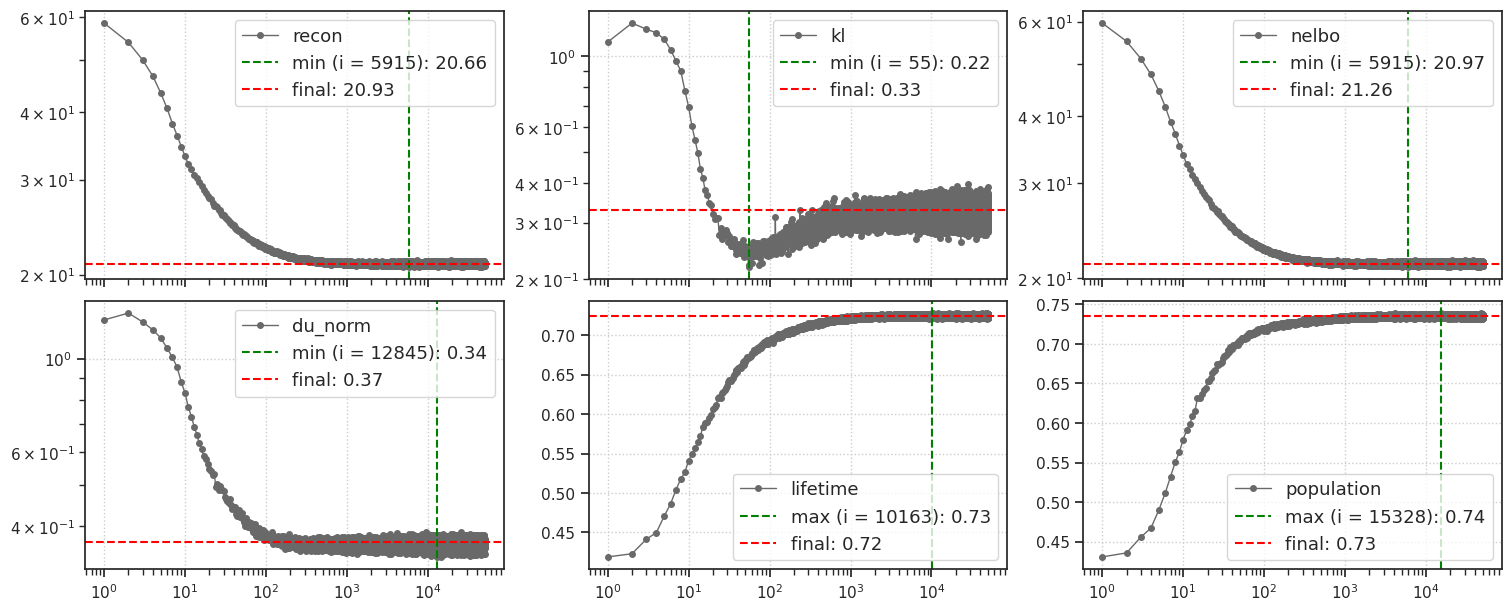

In [19]:
_ = plot_convergence(results_omni_plot, color='dimgrey')

(240, 1, 28, 28)

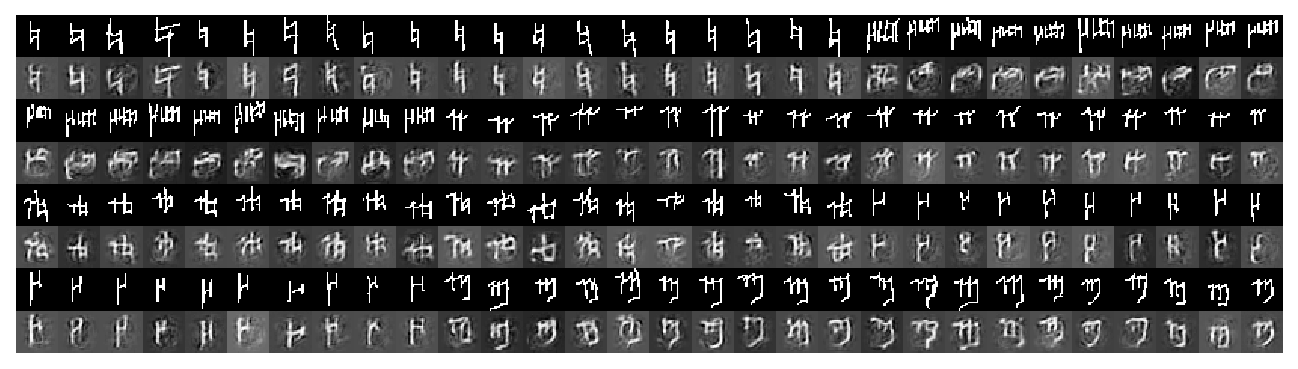

In [30]:
z = results_omni_plot['samples_final']
(z == 0).sum() / z.size * 100

54.8797607421875

In [33]:
output = tr.model.xtract_ftr(
    x=next(iter(omni['vld']))[0],
    return_extras=True,
    seq=range(1000),
).stack()

In [40]:
mse = tonp(output['loss_recon'])
mse.shape

(256, 1000)

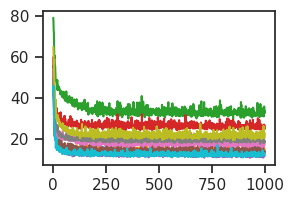

In [39]:
plt.plot(mse[:10].T)

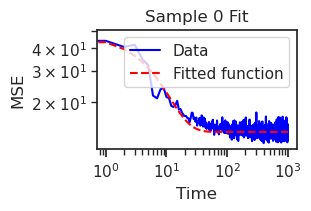

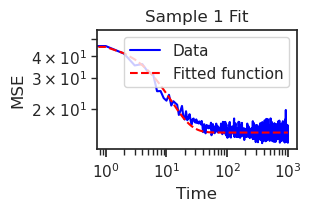

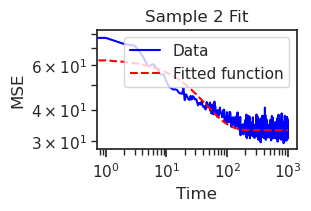

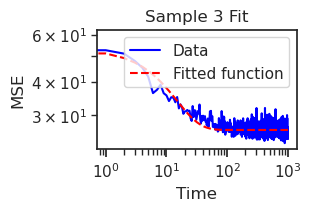

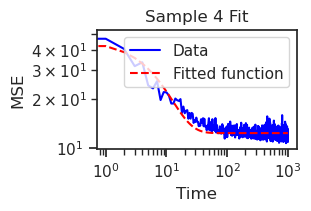

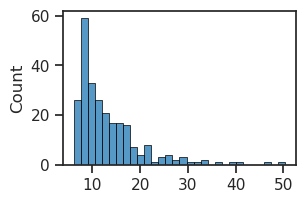

In [55]:
sns.histplot(decay_rates[~np.isnan(decay_rates)], bins=30, edgecolor='k');

In [60]:
shape = (-1, *tr.model.cfg.input_sz)

x = tonp(results_omni_plot['x'])
y = tonp(results_omni_plot['y'][:, -1, :])
y = y.reshape(shape)

order = np.argsort(decay_rates)
x = x[order]
y = y[order]

num = 30
x2p = []
for i in range(4):
    intvl = range(i * num, (i+1) * num)
    x2p.extend([x[intvl], y[intvl]])
x2p = np.concatenate(x2p)
x2p.shape

(240, 1, 28, 28)

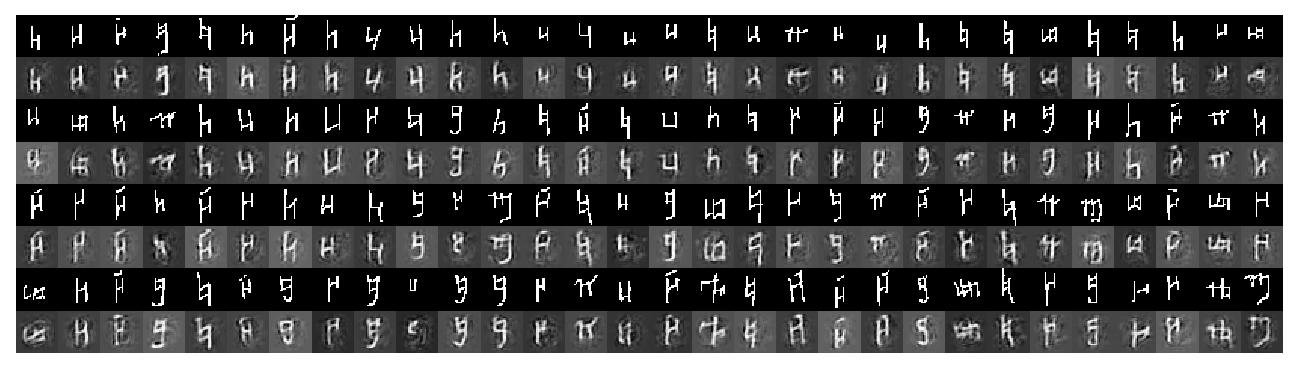

In [61]:
_ = plot_weights(x2p, nrows=int(len(x2p) / num), pad=0)

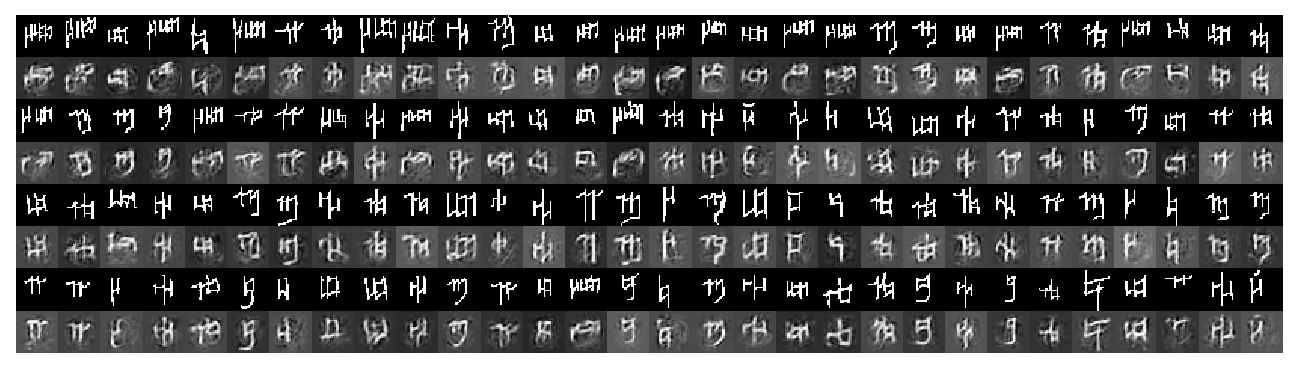

In [7]:
x, g = next(iter(emnist_vld))

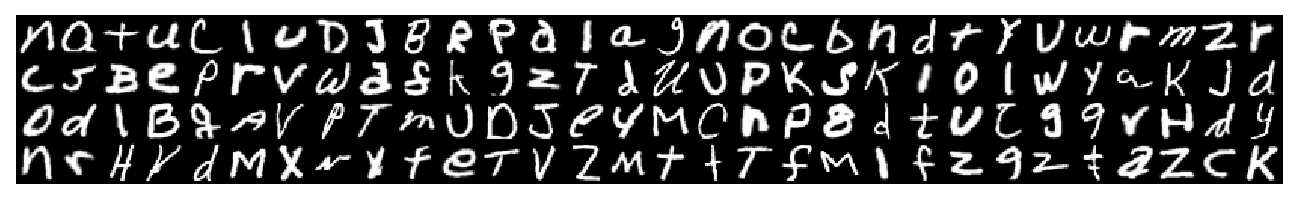

In [8]:
_ = plot_weights(x[:120], nrows=4, pad=0)

In [12]:
output = tr.model.xtract_ftr(
    x=x,
    seq=range(2000),
    return_extras=True,
).stack()

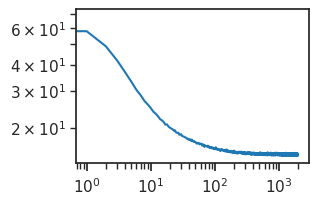

In [13]:
mse = tonp(output['loss_recon'].mean(0))
plt.loglog(mse)
plt.show()

In [14]:
mse

array([68.27263 , 57.806396, 48.913834, ..., 14.959688, 14.686888,
       14.940949], dtype=float32)

In [15]:
shape = (-1, *tr.model.cfg.input_sz)
recon = output['recon'][:, -1, :]
recon = recon.reshape(shape)

num = 30
x2p = []
for i in range(4):
    intvl = range(i * num, (i+1) * num)
    x2p.extend([x[intvl], recon[intvl]])
x2p = torch.cat(x2p)
x2p.shape

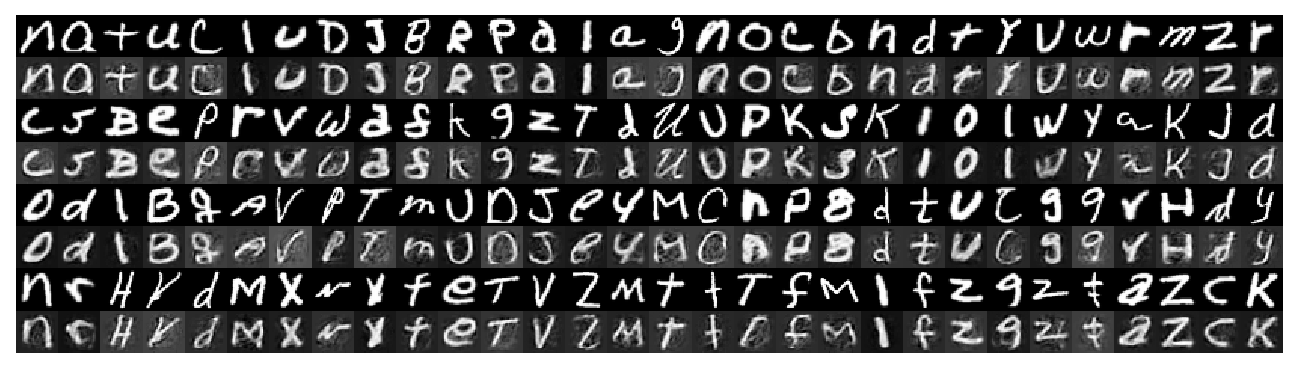

In [17]:
_ = plot_weights(x2p, nrows=int(len(x2p) / num), pad=0)

In [44]:
def ood_analysis(tr, dataset: str = 'Omniglot'):
    dl_trn, dl_vld = make_dataloader(
        dataset=dataset,
        device=tr.device,
        batch_size=tr.cfg.batch_size,
        shuffle=True,
    )
    
    output = tr.model.xtract_ftr(
        x=x,
        seq=range(2000),
        return_extras=True,
    ).stack()

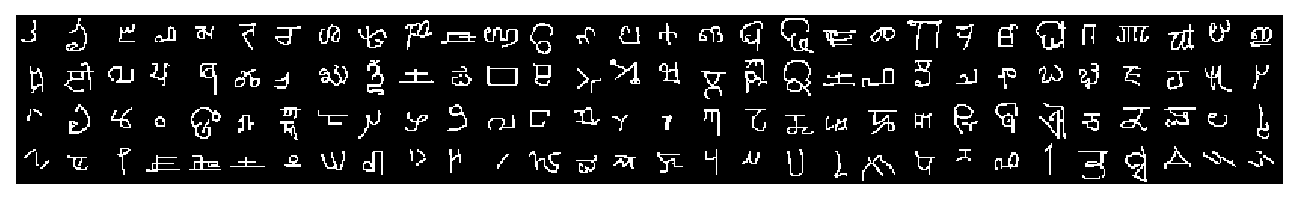

In [36]:
x, g = next(iter(dl_vld))
_ = plot_weights(x[:120], nrows=4, pad=0)

In [37]:
output = tr.model.xtract_ftr(
    x=x,
    seq=range(2000),
    return_extras=True,
).stack()

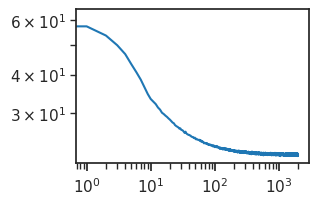

In [38]:
mse = tonp(output['loss_recon'].mean(0))
plt.loglog(mse)
plt.show()

In [39]:
mse

array([61.86393 , 57.321552, 53.53283 , ..., 22.077152, 21.996729,
       21.890215], dtype=float32)

In [40]:
shape = (-1, *tr.model.cfg.input_sz)
recon = output['recon'][:, -1, :]
recon = recon.reshape(shape)

In [41]:
num = 30
x2p = []
for i in range(4):
    intvl = range(i * num, (i+1) * num)
    x2p.extend([x[intvl], recon[intvl]])
x2p = torch.cat(x2p)
x2p.shape

torch.Size([240, 1, 28, 28])

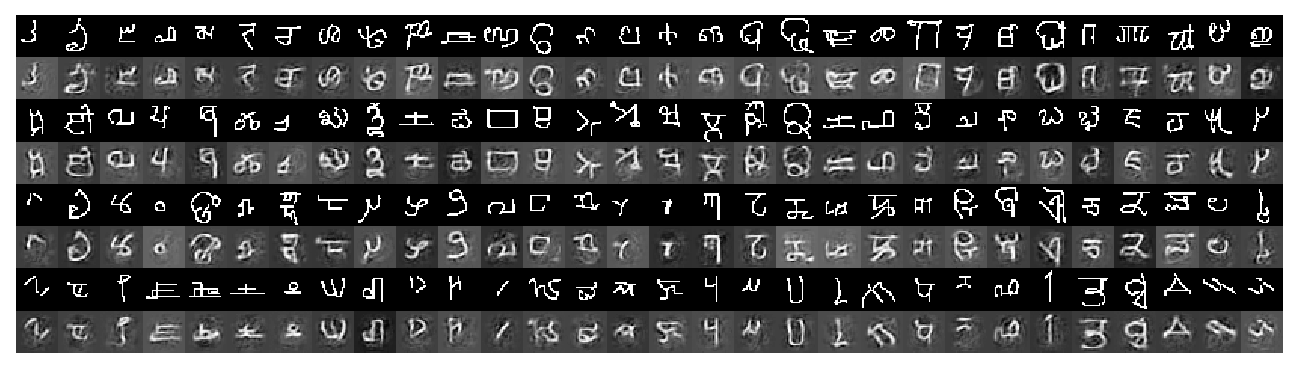

In [42]:
_ = plot_weights(x2p, nrows=int(len(x2p) / num), pad=0)